In [ ]:
# !jupyter nbconvert --to html /content/drive/MyDrive/Colab\ Notebooks/LMEM-SHAP/LMEM_T1D_shared.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/LMEM_T1D_shared.ipynb to html
[NbConvertApp] Writing 1682819 bytes to /content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/LMEM_T1D_shared.html


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data loader and creating DFs

In [1]:
!pip3 install researchpy
import numpy as np
import matplotlib.patches as mpatches
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import researchpy as rp
import glob
from scipy import io

def remove_outliers(df,columns,n_std):
    for col in columns:
        print('Working on column: {}'.format(col))
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

    
%load_ext google.colab.data_table

# %unload_ext google.colab.data_table

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Protocol J 

In [2]:
df_not = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/protocol-J_Dataset/preprocessed_data/-60minTo2.5hours_after_meal/df_not_-60minTo2.5hours_after_meal.csv',index_col=0).rename(columns={"Carbohydrate [gram]": "Carbs"})
df_50dec = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/protocol-J_Dataset/preprocessed_data/-60minTo2.5hours_after_meal/df_dec_-60minTo2.5hours_after_meal.csv',index_col=0).rename(columns={"Carbohydrate [gram]": "Carbs"})
df_mdg = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/protocol-J_Dataset/preprocessed_data/-60minTo2.5hours_after_meal/df_mdg_-60minTo2.5hours_after_meal.csv',index_col=0).rename(columns={"Carbohydrate [gram]": "Carbs"})
df_tabs = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/protocol-J_Dataset/preprocessed_data/-60minTo2.5hours_after_meal/df_tabs_-60minTo2.5hours_after_meal.csv',index_col=0).rename(columns={"Carbohydrate [gram]": "Carbs"})

In [3]:
df_not.head()

,Time,Timepoint,PtID,Glucose,Carbohydrate,HeartRate,Insulin
0,07:05:00,-60.0,1,NaN,NaN,NaN,NaN
1,07:06:00,-59.0,1,NaN,NaN,NaN,NaN
2,07:07:00,-58.0,1,NaN,NaN,NaN,NaN
3,07:08:00,-57.0,1,NaN,NaN,NaN,NaN
4,07:09:00,-56.0,1,101.0,NaN,NaN,NaN


In [ ]:
df_not.shape , df_50dec.shape , df_mdg.shape , df_tabs.shape , 

((3432, 7), (3718, 7), (4004, 7), (4004, 7))

In [ ]:
print(len(df_not.PtID.unique()), 
      len(df_tabs.PtID.unique()), 
      len(df_50dec.PtID.unique()), 
      len(df_mdg.PtID.unique()))



12 14 13 14


## generate 25thm 50th and 75th percentile of Insulin

In [ ]:
#Interpolation
# filling up NAN values in 5 minutes sampling rate

df_not_insulin_total_interpolated=pd.DataFrame()
for pt in df_not.PtID.unique():
  if pt==2 or pt==5 or pt==14:
    continue
  df_not_insulin_patient=df_not[df_not.PtID==pt]
  df_not_insulin_patient['Insulin'].interpolate(method='polynomial', order=1, inplace=True)
  df_not_insulin_patient=df_not_insulin_patient.round(2)
  df_not_insulin_patient ['Insulin']=  df_not_insulin_patient['Insulin'].fillna(method='bfill')
  df_not_insulin_patient ['Insulin']=  df_not_insulin_patient['Insulin'].fillna(method='ffill')

  df_not_insulin_total_interpolated=pd.concat([df_not_insulin_total_interpolated ,df_not_insulin_patient ], ignore_index=True)


df_50dec_insulin_total_interpolated=pd.DataFrame()
for pt in df_50dec.PtID.unique():

  df_50dec_insulin_patient=df_50dec[df_50dec.PtID==pt]
  df_50dec_insulin_patient['Insulin'].interpolate(method='polynomial', order=1, inplace=True)
  df_50dec_insulin_patient=df_50dec_insulin_patient.round(2)
  df_50dec_insulin_patient ['Insulin']=  df_50dec_insulin_patient['Insulin'].fillna(method='bfill')
  df_50dec_insulin_patient ['Insulin']=  df_50dec_insulin_patient['Insulin'].fillna(method='ffill')
 
  df_50dec_insulin_total_interpolated=pd.concat([df_50dec_insulin_total_interpolated ,df_50dec_insulin_patient ], ignore_index=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6915: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Text(0.5, 1.0, 'Insulin level (interpolated) for all patients in Protocol J ')

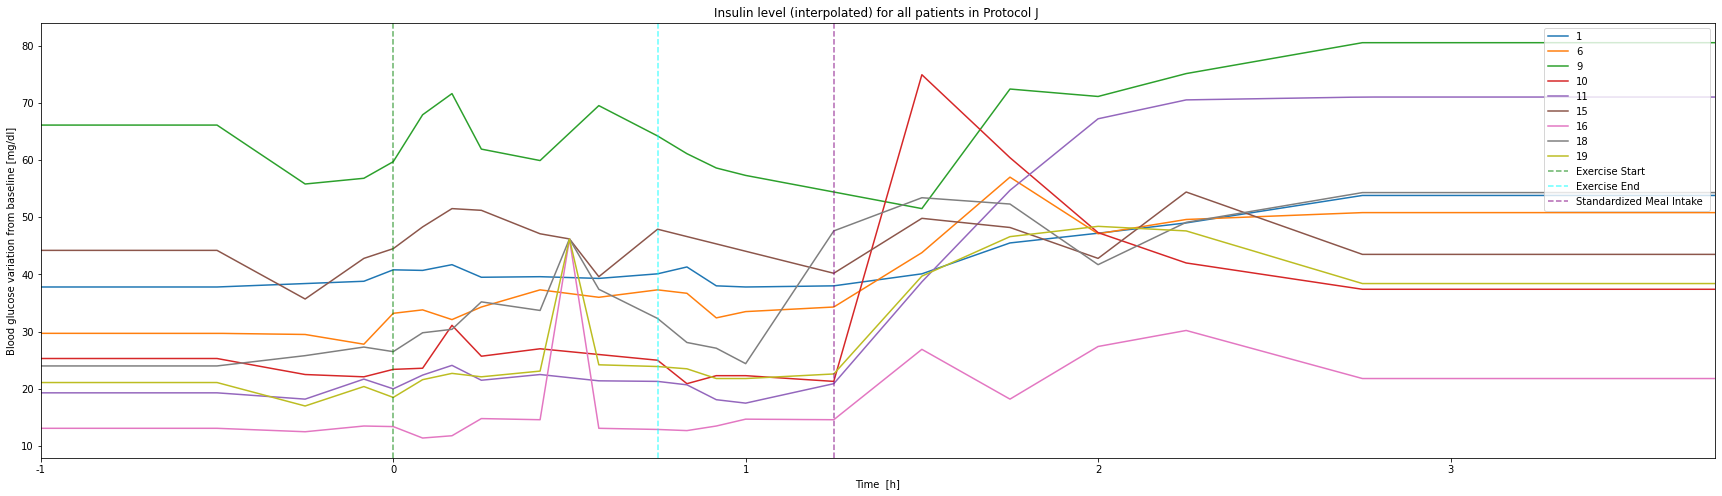

In [ ]:
plt.figure(figsize=(30,8))
for pt in df_not_insulin_total_interpolated.PtID.unique():
  plt.plot(df_not_insulin_total_interpolated.Insulin[df_not_insulin_total_interpolated.PtID==pt].values, label=pt)
  plt.legend()

plt.margins(x=0)
plt.axvline(x =60, color = 'green', label = 'Exercise Start', alpha=0.6, linestyle='--')
plt.axvline(x =60+45, color = 'cyan', label = 'Exercise End', alpha=0.6, linestyle='--')
plt.axvline(x =60+45+30, color = 'purple', label = 'Standardized Meal Intake ', alpha=0.6,linestyle='--')
plt.locator_params(axis='x', nbins=285/15)
plt.xticks(ticks=np.arange(0, len(df_not_insulin_total_interpolated.Insulin[df_not_insulin_total_interpolated.PtID==pt])+1, 60),
           labels=np.arange(int(-60/60), int((len(df_not_insulin_total_interpolated.Insulin[df_not_insulin_total_interpolated.PtID==pt])-60)/60)+1))
plt.legend(loc=1)
plt.xlabel('Time  [h]')
plt.ylabel('Blood glucose variation from baseline [mg/dl]' )

plt.title('Insulin level (interpolated) for all patients in Protocol J ')
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/insulin/df_not_insulin_total_interpolated.png', dti=300)

In [ ]:
df_not_insulin_ex_pw_interpolated = pd.DataFrame()
df_not_insulin_ex_pw_interpolated_normalized = pd.DataFrame()

df_50dec_insulin_ex_pw_interpolated = pd.DataFrame()
df_50dec_insulin_ex_pw_interpolated_normalized = pd.DataFrame()


for patient_id in df_not_insulin_total_interpolated.PtID.unique():
  df_not_insulin_ex_pw_interpolated_normalized['PtID_'+str(patient_id)] = df_not_insulin_total_interpolated[df_not_insulin_total_interpolated.PtID==patient_id].Insulin.reset_index(drop=True) - df_not_insulin_total_interpolated[df_not_insulin_total_interpolated.PtID==patient_id].Insulin.iloc[0]
  df_not_insulin_ex_pw_interpolated['PtID_'+str(patient_id)] = df_not_insulin_total_interpolated[df_not_insulin_total_interpolated.PtID==patient_id].Insulin.reset_index(drop=True)

# df_not_insulin_ex_pw_interpolated.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/insulin/df_not_insulin_ex_pw_interpolated.csv', index=False)

for patient_id in df_50dec_insulin_total_interpolated.PtID.unique():
  df_50dec_insulin_ex_pw_interpolated_normalized['PtID_'+str(patient_id)] = df_50dec_insulin_total_interpolated[df_50dec_insulin_total_interpolated.PtID==patient_id].Insulin.reset_index(drop=True) - df_50dec_insulin_total_interpolated[df_50dec_insulin_total_interpolated.PtID==patient_id].Insulin.iloc[0]
  df_50dec_insulin_ex_pw_interpolated['PtID_'+str(patient_id)] = df_50dec_insulin_total_interpolated[df_50dec_insulin_total_interpolated.PtID==patient_id].Insulin.reset_index(drop=True) 
# df_50dec_insulin_ex_pw_interpolated.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/insulin/df_50dec_insulin_ex_pw_interpolated.csv', index=False)



In [ ]:
df_not_insulin_75percentile_interpolated = df_not_insulin_ex_pw_interpolated.reset_index(drop=True).T.quantile(.75)
df_not_insulin_25percentile_interpolated = df_not_insulin_ex_pw_interpolated.reset_index(drop=True).T.quantile(.25)
df_not_insulin_50percentile_interpolated = df_not_insulin_ex_pw_interpolated.reset_index(drop=True).T.quantile(.5)

# df_not_insulin_75percentile_interpolated.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/insulin/df_not_insulin_interpolated_75percentile.csv', index=False)
# df_not_insulin_25percentile_interpolated.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/insulin/df_not_insulin_interpolated_25percentile.csv', index=False)
# df_not_insulin_50percentile_interpolated.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/insulin/df_not_insulin_interpolated_50percentile.csv', index=False)


df_50dec_insulin_75percentile_interpolated = df_50dec_insulin_ex_pw_interpolated.reset_index(drop=True).T.quantile(.75)
df_50dec_insulin_25percentile_interpolated = df_50dec_insulin_ex_pw_interpolated.reset_index(drop=True).T.quantile(.25)
df_50dec_insulin_50percentile_interpolated = df_50dec_insulin_ex_pw_interpolated.reset_index(drop=True).T.quantile(.5)

# df_50dec_insulin_75percentile_interpolated.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/insulin/df_50dec_insulin_interpolated_75percentile.csv', index=False)
# df_50dec_insulin_25percentile_interpolated.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/insulin/df_50dec_insulin_interpolated_25percentile.csv', index=False)
# df_50dec_insulin_50percentile_interpolated.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/insulin/df_50dec_insulin_interpolated_50percentile.csv', index=False)


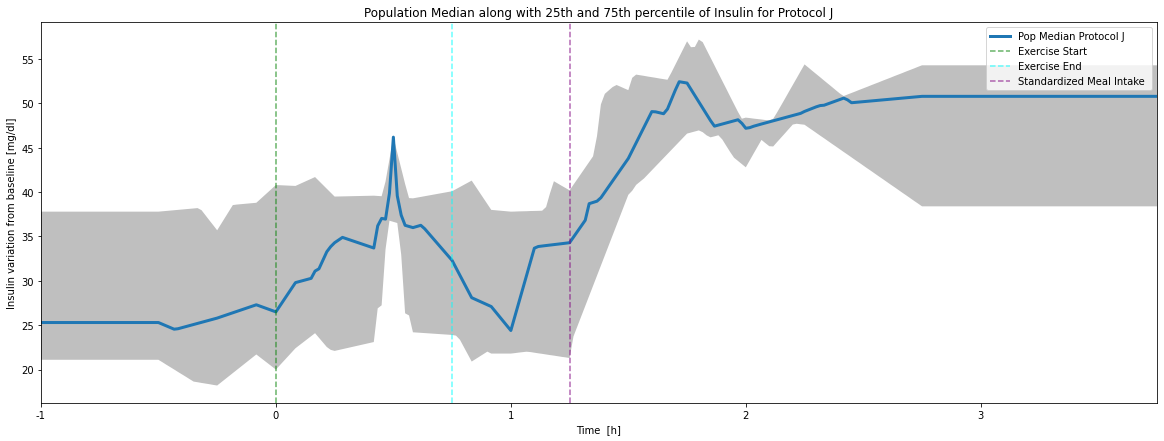

In [ ]:
plt.figure(figsize=(20,7))
plt.margins(x=0)
plt.plot(df_not_insulin_50percentile_interpolated, label='Pop Median Protocol J', linewidth=3)
plt.fill_between(range(len(df_not_insulin_25percentile_interpolated.values)), df_not_insulin_75percentile_interpolated.values, df_not_insulin_25percentile_interpolated.values,facecolor='gray', alpha=0.5)

plt.axvline(x =60, color = 'green', label = 'Exercise Start', alpha=0.6, linestyle='--')
plt.axvline(x =60+45, color = 'cyan', label = 'Exercise End', alpha=0.6, linestyle='--')
plt.axvline(x =60+45+30, color = 'purple', label = 'Standardized Meal Intake ', alpha=0.6,linestyle='--')
plt.locator_params(axis='x', nbins=285/15)
plt.xticks(ticks=np.arange(0, len(df_not_insulin_50percentile_interpolated)+1, 60), labels=np.arange(int(-60/60), int((len(df_not_insulin_50percentile_interpolated)-60)/60)+1))
plt.legend(loc=2)
plt.xlabel('Time  [h]')
plt.ylabel('Insulin variation from baseline [mg/dl]' )

plt.legend()

plt.title('Population Median along with 25th and 75th percentile of Insulin for Protocol J' )
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/insulin/protoclJ_control_trial_median_Insulin.png', dti=600)

plt.show()


## genrate and save 25th, 50th and 75th percentile (amomg all patients) - for interpolated data

In [ ]:
#Interpolation
# filling up NAN values in 5 minutes sampling rate

df_not_total_interpolated=pd.DataFrame()
for pt in df_not.PtID.unique():
  if pt==2 or pt==5 or pt==14:
    continue
  df_not_patient=df_not[df_not.PtID==pt]
  df_not_patient['Glucose'].interpolate(method='polynomial', order=1, inplace=True)
  df_not_patient=df_not_patient.round(2)
  df_not_patient ['Glucose']=  df_not_patient['Glucose'].fillna(method='bfill')
  df_not_patient ['Glucose']=  df_not_patient['Glucose'].fillna(method='ffill')
  # plt.plot(df_not_patient['Glucose'].values)
  # plt.savefig('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_not_pw/plots/interpolated_patient_'+str(pt)+'.png', dti=200)
  # plt.show()
  df_not_total_interpolated=pd.concat([df_not_total_interpolated ,df_not_patient ], ignore_index=True)



df_50dec_total_interpolated=pd.DataFrame()
for pt in df_50dec.PtID.unique():

  df_50dec_patient=df_50dec[df_50dec.PtID==pt]
  df_50dec_patient['Glucose'].interpolate(method='polynomial', order=1, inplace=True)
  df_50dec_patient=df_50dec_patient.round(2)
  df_50dec_patient ['Glucose']=  df_50dec_patient['Glucose'].fillna(method='bfill')
  df_50dec_patient ['Glucose']=  df_50dec_patient['Glucose'].fillna(method='ffill')
  # plt.plot(df_50dec_patient['Glucose'].values)
  # plt.savefig('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_50dec_pw/plots/interpolated_patient_'+str(pt)+'.png', dti=200)
  # plt.show()
  df_50dec_total_interpolated=pd.concat([df_50dec_total_interpolated ,df_50dec_patient ], ignore_index=True)

  df_tabs_total_interpolated=pd.DataFrame()
for pt in df_tabs.PtID.unique():

  df_tabs_patient=df_tabs[df_tabs.PtID==pt]
  df_tabs_patient['Glucose'].interpolate(method='polynomial', order=1, inplace=True)
  df_tabs_patient=df_tabs_patient.round(2)
  df_tabs_patient ['Glucose']=  df_tabs_patient['Glucose'].fillna(method='bfill')
  df_tabs_patient ['Glucose']=  df_tabs_patient['Glucose'].fillna(method='ffill')
  # plt.plot(df_tabs_patient['Glucose'].values)
  # plt.savefig('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_tabs_pw/plots/interpolated_patient_'+str(pt)+'.png', dti=200)
  # plt.show()
  df_tabs_total_interpolated=pd.concat([df_tabs_total_interpolated ,df_tabs_patient ], ignore_index=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6915: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
df_not_ex_pw_interpolated = pd.DataFrame()
df_not_ex_pw_interpolated_normalized = pd.DataFrame()

df_50dec_ex_pw_interpolated = pd.DataFrame()
df_50dec_ex_pw_interpolated_normalized = pd.DataFrame()

df_tabs_ex_pw_interpolated = pd.DataFrame()
df_tabs_ex_pw_interpolated_normalized = pd.DataFrame()

# df_mdg_ex_pw = pd.DataFrame()
# df_mdg_ex_pw_normalized = pd.DataFrame()



for patient_id in df_not_total_interpolated.PtID.unique():
  df_not_ex_pw_interpolated_normalized['PtID_'+str(patient_id)] = df_not_total_interpolated[df_not_total_interpolated.PtID==patient_id].Glucose.reset_index(drop=True) - df_not_total_interpolated[df_not_total_interpolated.PtID==patient_id].Glucose.iloc[0]
  df_not_ex_pw_interpolated['PtID_'+str(patient_id)] = df_not_total_interpolated[df_not_total_interpolated.PtID==patient_id].Glucose.reset_index(drop=True)

# df_not_ex_pw_interpolated.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_not_ex_pw_interpolated.csv', index=False)

for patient_id in df_50dec_total_interpolated.PtID.unique():
  df_50dec_ex_pw_interpolated_normalized['PtID_'+str(patient_id)] = df_50dec_total_interpolated[df_50dec_total_interpolated.PtID==patient_id].Glucose.reset_index(drop=True) - df_50dec_total_interpolated[df_50dec_total_interpolated.PtID==patient_id].Glucose.iloc[0]
  df_50dec_ex_pw_interpolated['PtID_'+str(patient_id)] = df_50dec_total_interpolated[df_50dec_total_interpolated.PtID==patient_id].Glucose.reset_index(drop=True) 
# df_50dec_ex_pw_interpolated.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_50dec_ex_pw_interpolated.csv', index=False)


for patient_id in df_tabs_total_interpolated.PtID.unique():
  df_tabs_ex_pw_interpolated_normalized['PtID_'+str(patient_id)] = df_tabs_total_interpolated[df_tabs_total_interpolated.PtID==patient_id].Glucose.reset_index(drop=True) - df_tabs_total_interpolated[df_tabs_total_interpolated.PtID==patient_id].Glucose.iloc[0]
  df_tabs_ex_pw_interpolated['PtID_'+str(patient_id)] = df_tabs_total_interpolated[df_tabs_total_interpolated.PtID==patient_id].Glucose.reset_index(drop=True) 
# df_tabs_ex_pw_interpolated.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_tabs_ex_pw_interpolated.csv', index=False)


# for patient_id in df_mdg_total.PtID.unique():
#   df_mdg_ex_pw_normalized['PtID_'+str(patient_id)] = df_mdg_total[df_mdg_total.PtID==patient_id].Glucose.reset_index(drop=True) - df_mdg_total[df_mdg_total.PtID==patient_id].Glucose.iloc[0]
#   df_mdg_ex_pw['PtID_'+str(patient_id)] = df_mdg_total[df_mdg_total.PtID==patient_id].Glucose.reset_index(drop=True) 



In [ ]:
df_not_75percentile_interpolated = df_not_ex_pw_interpolated.reset_index(drop=True).T.quantile(.75)
df_not_25percentile_interpolated = df_not_ex_pw_interpolated.reset_index(drop=True).T.quantile(.25)
df_not_50percentile_interpolated = df_not_ex_pw_interpolated.reset_index(drop=True).T.quantile(.5)

# df_not_75percentile_interpolated.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_not_interpolated_75percentile.csv', index=False)
# df_not_25percentile_interpolated.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_not_interpolated_25percentile.csv', index=False)
# df_not_50percentile_interpolated.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_not_interpolated_50percentile.csv', index=False)


df_50dec_75percentile_interpolated = df_50dec_ex_pw_interpolated.reset_index(drop=True).T.quantile(.75)
df_50dec_25percentile_interpolated = df_50dec_ex_pw_interpolated.reset_index(drop=True).T.quantile(.25)
df_50dec_50percentile_interpolated = df_50dec_ex_pw_interpolated.reset_index(drop=True).T.quantile(.5)

# df_50dec_75percentile_interpolated.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_50dec_interpolated_75percentile.csv', index=False)
# df_50dec_25percentile_interpolated.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_50dec_interpolated_25percentile.csv', index=False)
# df_50dec_50percentile_interpolated.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_50dec_interpolated_50percentile.csv', index=False)



df_tabs_75percentile_interpolated = df_tabs_ex_pw_interpolated.reset_index(drop=True).T.quantile(.75)
df_tabs_25percentile_interpolated = df_tabs_ex_pw_interpolated.reset_index(drop=True).T.quantile(.25)
df_tabs_50percentile_interpolated = df_tabs_ex_pw_interpolated.reset_index(drop=True).T.quantile(.5)

# df_tabs_75percentile_interpolated.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_tabs_interpolated_75percentile.csv', index=False)
# df_tabs_25percentile_interpolated.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_tabs_interpolated_25percentile.csv', index=False)
# df_tabs_50percentile_interpolated.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_tabs_interpolated_50percentile.csv', index=False)


Text(0.5, 1.0, 'Boxplot of Glycemia for Protocol J Patients')

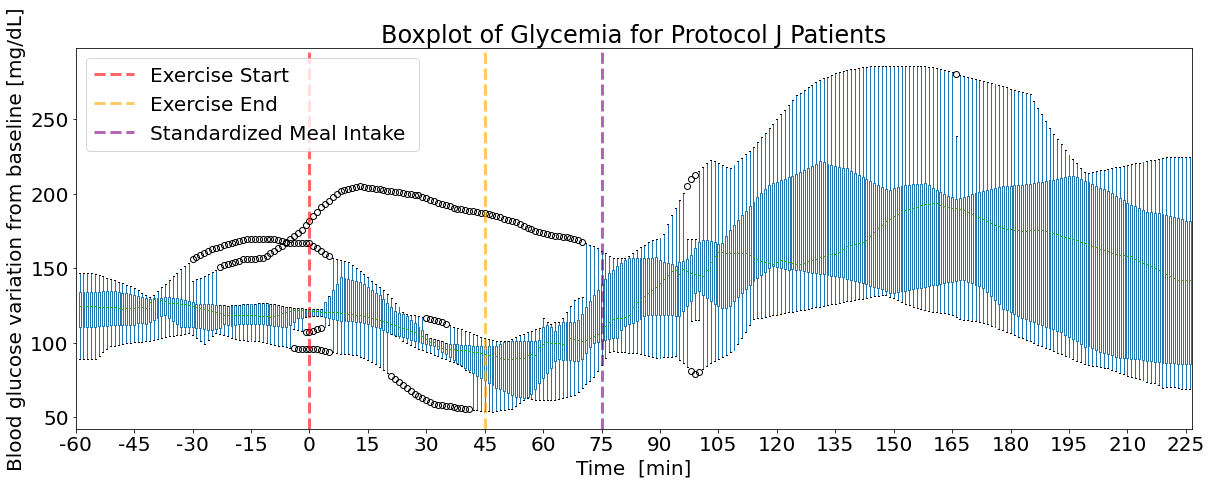

In [ ]:
plt.rcParams.update({'font.size': 20})

offset_to_125 = 125 - df_not_50percentile_interpolated.values[0]
(df_not_ex_pw_interpolated+offset_to_125).T.boxplot(grid=False, figsize=(20, 7))
plt.axvline(x =60, color = 'red', label = 'Exercise Start',linewidth=3, alpha=0.6, linestyle='--')
plt.axvline(x =60+45, color = 'orange', label = 'Exercise End',linewidth=3, alpha=0.6, linestyle='--')
plt.axvline(x =60+45+30, color = 'purple', label = 'Standardized Meal Intake ',linewidth=3, alpha=0.6,linestyle='--')
plt.locator_params(axis='x', nbins=285/15)
plt.xticks(ticks=np.arange(0, len(df_not_ex_pw_interpolated)+1, 15), labels=np.arange(-60, 226, 15))
plt.legend(loc=2)
plt.xlabel('Time  [min]')
plt.ylabel('Blood glucose variation from baseline [mg/dL]' )
plt.title('Boxplot of Glycemia for Protocol J Patients')
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/plots/protocolJ_data_boxplot_control_trial_15min_xticks_offset_adjusted.png', dti=320)


# simulated data

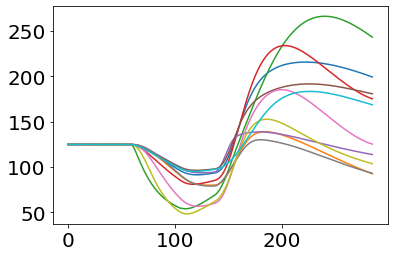

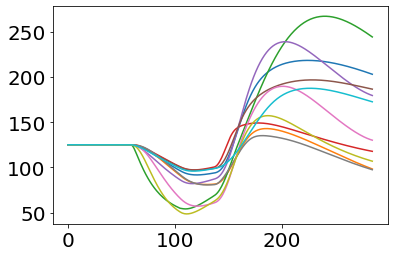

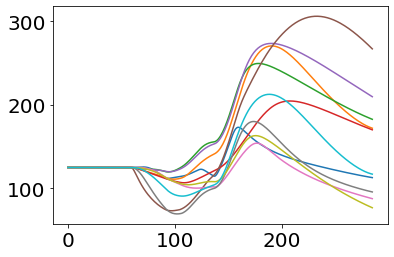

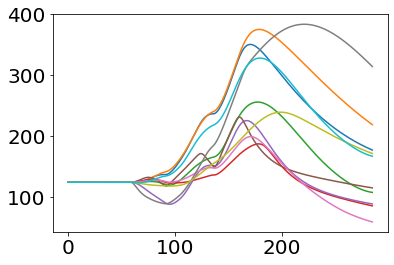

In [ ]:
start_exer=225
len_workout=45
df_control_simulated_pw=pd.DataFrame(index=range(286))
for file in glob.glob('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_control/*.mat'):
  matlab_dataloader = io.loadmat(file)
  pt_id=int(file.split('/')[-1].split('_')[-1].split('.')[0])
  data_control_pw = matlab_dataloader['glycemia'][start_exer-60:int(start_exer+len_workout+30+2.5*60+1)]
  plt.plot(data_control_pw)
  df_control_simulated_pw['PtID_'+str(pt_id)]=data_control_pw
plt.show()
df_control_simulated_pw.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_control/df_control_simulated_pw.csv', index=False)


df_50reduc_simulated_pw=pd.DataFrame(index=range(286))
for file in glob.glob('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_50reduc/*.mat'):
  matlab_dataloader = io.loadmat(file)
  pt_id=int(file.split('/')[-1].split('_')[-1].split('.')[0])
  data_50reduc_pw = matlab_dataloader['glycemia'][start_exer-60:int(start_exer+len_workout+30+2.5*60+1)]
  plt.plot(data_50reduc_pw)
  df_50reduc_simulated_pw['PtID_'+str(pt_id)]=data_50reduc_pw
plt.show()
df_50reduc_simulated_pw.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_50reduc/df_50reduc_simulated_pw.csv', index=False)

df_tabs_1_simulated_pw=pd.DataFrame(index=range(286))
for file in glob.glob('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_tabs_1/*.mat'):
  matlab_dataloader = io.loadmat(file)
  pt_id=int(file.split('/')[-1].split('_')[-1].split('.')[0])
  data_tabs_1_pw = matlab_dataloader['glycemia'][start_exer-60:int(start_exer+len_workout+30+2.5*60+1)]
  plt.plot(data_tabs_1_pw)
  df_tabs_1_simulated_pw['PtID_'+str(pt_id)]=data_tabs_1_pw
plt.show()
df_tabs_1_simulated_pw.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_tabs_1/df_tabs_1_simulated_pw.csv', index=False)


df_tabs_2_simulated_pw=pd.DataFrame(index=range(286))
for file in glob.glob('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_tabs_2/*.mat'):
  matlab_dataloader = io.loadmat(file)
  pt_id=int(file.split('/')[-1].split('_')[-1].split('.')[0])
  data_tabs_2_pw = matlab_dataloader['glycemia'][start_exer-60:int(start_exer+len_workout+30+2.5*60+1)]
  plt.plot(data_tabs_2_pw)
  df_tabs_2_simulated_pw['PtID_'+str(pt_id)]=data_tabs_2_pw
plt.show()
df_tabs_2_simulated_pw.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_tabs_2/df_tabs_2_simulated_pw.csv', index=False)


In [ ]:
df_control_simulated_75percentile = df_control_simulated_pw.reset_index(drop=True).T.quantile(.75)
df_control_simulated_25percentile = df_control_simulated_pw.reset_index(drop=True).T.quantile(.25)
df_control_simulated_50percentile = df_control_simulated_pw.reset_index(drop=True).T.quantile(.5)

df_control_simulated_75percentile.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_control/df_control_simulated_75percentile.csv', index=False)
df_control_simulated_25percentile.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_control/df_control_simulated_25percentile.csv', index=False)
df_control_simulated_50percentile.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_control/df_control_simulated_50percentile.csv', index=False)



df_50reduc_simulated_75percentile = df_50reduc_simulated_pw.reset_index(drop=True).T.quantile(.75)
df_50reduc_simulated_25percentile = df_50reduc_simulated_pw.reset_index(drop=True).T.quantile(.25)
df_50reduc_simulated_50percentile = df_50reduc_simulated_pw.reset_index(drop=True).T.quantile(.5)

df_50reduc_simulated_75percentile.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_50reduc/df_50reduc_simulated_75percentile.csv', index=False)
df_50reduc_simulated_25percentile.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_50reduc/df_50reduc_simulated_25percentile.csv', index=False)
df_50reduc_simulated_50percentile.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_50reduc/df_50reduc_simulated_50percentile.csv', index=False)

df_tabs_1_simulated_75percentile = df_tabs_1_simulated_pw.reset_index(drop=True).T.quantile(.75)
df_tabs_1_simulated_25percentile = df_tabs_1_simulated_pw.reset_index(drop=True).T.quantile(.25)
df_tabs_1_simulated_50percentile = df_tabs_1_simulated_pw.reset_index(drop=True).T.quantile(.5)

df_tabs_1_simulated_75percentile.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_tabs_1/df_tabs_1_simulated_75percentile.csv', index=False)
df_tabs_1_simulated_25percentile.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_tabs_1/df_tabs_1_simulated_25percentile.csv', index=False)
df_tabs_1_simulated_50percentile.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_tabs_1/df_tabs_1_simulated_50percentile.csv', index=False)

df_tabs_2_simulated_75percentile = df_tabs_2_simulated_pw.reset_index(drop=True).T.quantile(.75)
df_tabs_2_simulated_25percentile = df_tabs_2_simulated_pw.reset_index(drop=True).T.quantile(.25)
df_tabs_2_simulated_50percentile = df_tabs_2_simulated_pw.reset_index(drop=True).T.quantile(.5)

df_tabs_2_simulated_75percentile.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_tabs_2/df_tabs_2_simulated_75percentile.csv', index=False)
df_tabs_2_simulated_25percentile.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_tabs_2/df_tabs_2_simulated_25percentile.csv', index=False)
df_tabs_2_simulated_50percentile.to_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_tabs_2/df_tabs_2_simulated_50percentile.csv', index=False)

# Comparing simulated data vs protocol J dataset - Control Trial

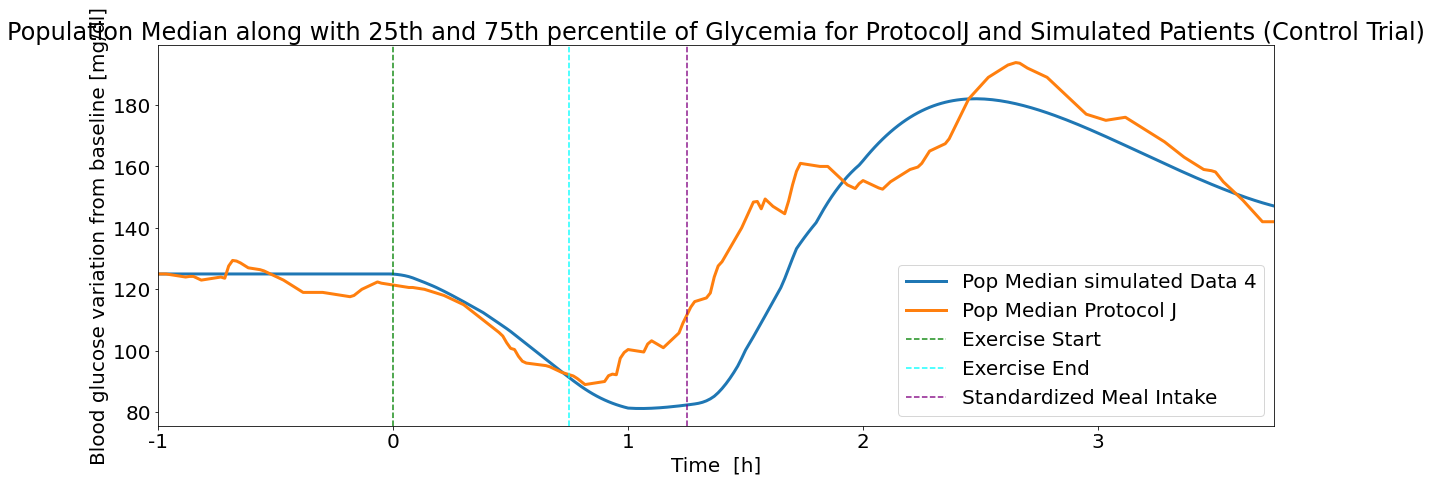

In [ ]:
# df_control_simulated_50percentile_1= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data/df_simulated_50percentile.csv')
# df_control_simulated_50percentile_2= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_2/df_simulated_50percentile.csv')
# df_control_simulated_50percentile_3= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_3/df_simulated_50percentile.csv')
df_control_simulated_50percentile_4= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_control/df_control_simulated_50percentile.csv')

df_not_50percentile_interpolated = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_not_interpolated_50percentile.csv').values[:,0]

plt.figure(figsize=(20,7))
plt.margins(x=0)
offset_to_125 = 125 - df_not_50percentile_interpolated[0]

# plt.plot(df_control_simulated_50percentile_1, label='Pop Median simulated Data 1', linewidth=3)
# plt.plot(df_control_simulated_50percentile_2, label='Pop Median simulated Data 2', linewidth=3)
# plt.plot(df_control_simulated_50percentile_3, label='Pop Median simulated Data 3', linewidth=3)
plt.plot(df_control_simulated_50percentile_4, label='Pop Median simulated Data 4', linewidth=3)

plt.plot(df_not_50percentile_interpolated+offset_to_125, label='Pop Median Protocol J', linewidth=3)

plt.axvline(x =60, color = 'green', label = 'Exercise Start', alpha=0.9, linestyle='--')
plt.axvline(x =60+45, color = 'cyan', label = 'Exercise End', alpha=0.9, linestyle='--')
plt.axvline(x =60+45+30, color = 'purple', label = 'Standardized Meal Intake ', alpha=0.9,linestyle='--')
plt.locator_params(axis='x', nbins=285/15)
plt.xticks(ticks=np.arange(0, len(df_control_simulated_pw)+1, 60), labels=np.arange(int(-60/60), int((len(df_control_simulated_pw)-60)/60)+1))
plt.legend(loc=2)
plt.xlabel('Time  [h]')
plt.ylabel('Blood glucose variation from baseline [mg/dl]' )

plt.legend()

plt.title('Population Median along with 25th and 75th percentile of Glycemia for ProtocolJ and Simulated Patients (Control Trial)')
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/plots/protoclJ_simulated_data_4_control_trial_median.png', dti=600)

plt.show()


In [ ]:
df_control_simulated_pw= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_control/df_control_simulated_pw.csv')
df_not_ex_pw_interpolated= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_not_ex_pw_interpolated.csv')


df_control_simulated_75percentile= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_control/df_control_simulated_75percentile.csv')
df_control_simulated_25percentile= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_control/df_control_simulated_25percentile.csv')
df_control_simulated_50percentile= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_control/df_control_simulated_50percentile.csv')

df_not_75percentile_interpolated= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_not_interpolated_75percentile.csv')
df_not_25percentile_interpolated= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_not_interpolated_25percentile.csv')
df_not_50percentile_interpolated= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_not_interpolated_50percentile.csv')



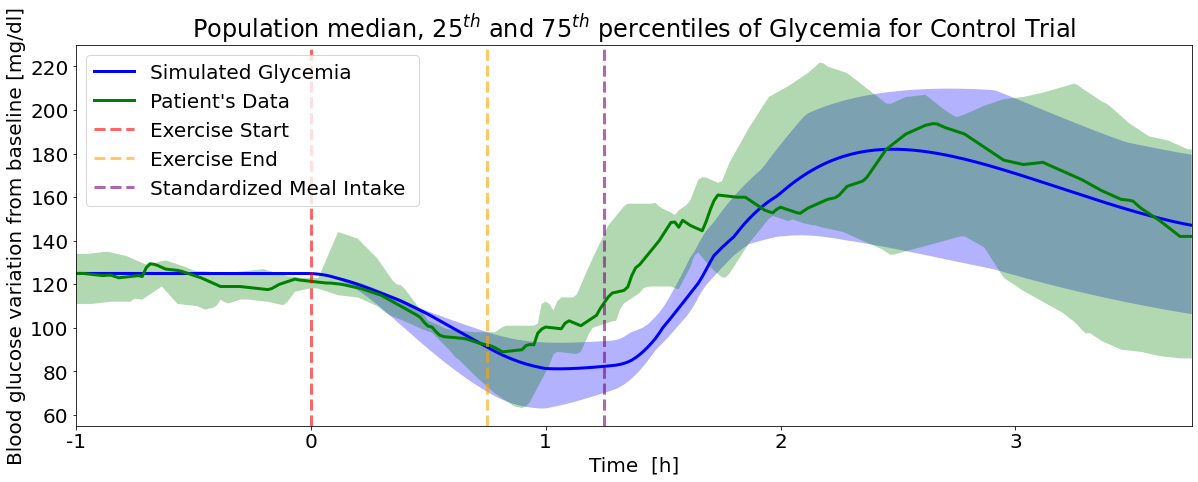

In [ ]:
# Both plots together

plt.figure(figsize=(20,7))
plt.margins(x=0)
offset_to_125 = 125 - df_not_50percentile_interpolated.values[:,0][0]
plt.fill_between(range(len(df_control_simulated_75percentile.values)), df_control_simulated_75percentile.values[:,0],
                 df_control_simulated_25percentile.values[:,0],facecolor='blue', alpha=0.3)
plt.plot(df_control_simulated_50percentile.values, linewidth=3 , color='blue' , label='Simulated Glycemia')


plt.fill_between(range(len(df_not_75percentile_interpolated)), df_not_75percentile_interpolated.values[:,0]+offset_to_125, 
                 df_not_25percentile_interpolated.values[:,0]+offset_to_125 ,facecolor='green', alpha=0.3)
plt.plot(df_not_50percentile_interpolated.values[:,0]+offset_to_125, linewidth=3,  color='green', label= 'Patient\'s Data')


plt.axvline(x =60, color = 'red', label = 'Exercise Start',linewidth=3, alpha=0.6, linestyle='--')
plt.axvline(x =60+45, color = 'orange', label = 'Exercise End',linewidth=3, alpha=0.6, linestyle='--')
plt.axvline(x =60+45+30, color = 'purple', label = 'Standardized Meal Intake ',linewidth=3, alpha=0.6,linestyle='--')
plt.locator_params(axis='x', nbins=285/15)
plt.xticks(ticks=np.arange(0, len(df_control_simulated_pw)+1, 60), labels=np.arange(int(-60/60), int((len(df_control_simulated_pw)-60)/60)+1))
plt.legend(loc=2)
plt.xlabel('Time  [h]')
plt.ylabel('Blood glucose variation from baseline [mg/dl]' )
plt.title('Population median, $25^{th}$ and $75^{th}$ percentiles of Glycemia for Control Trial')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/plots/compariosn_control_trial_percentiles_simulated_data_4.png', dti=320)

plt.show()

# Comparing simulated data vs protocol J dataset - 50% Insulin Reduction Trial

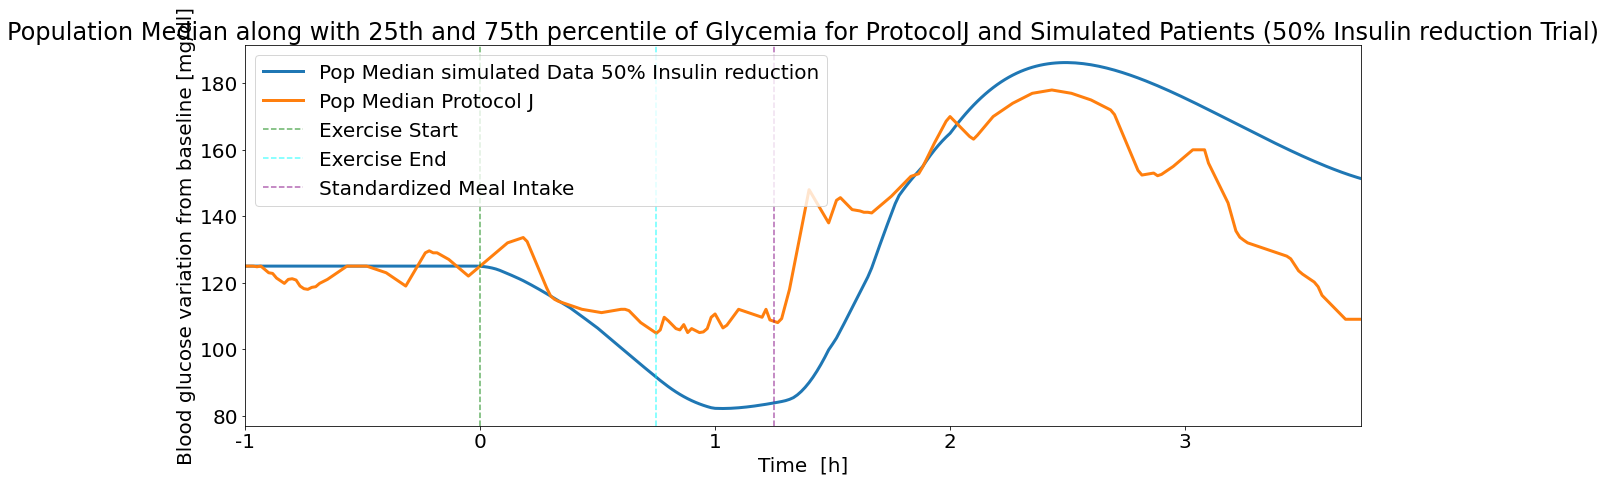

In [ ]:
df_50reduc_simulated_50percentile= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_50reduc/df_50reduc_simulated_50percentile.csv')
df_50dec_50percentile_interpolated = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_50dec_interpolated_50percentile.csv').values[:,0]

plt.figure(figsize=(20,7))
plt.margins(x=0)
offset_to_125 = 125 - df_50dec_50percentile_interpolated[0]

plt.plot(df_50reduc_simulated_50percentile, label='Pop Median simulated Data 50% Insulin reduction', linewidth=3)
plt.plot(df_50dec_50percentile_interpolated+offset_to_125, label='Pop Median Protocol J', linewidth=3)

plt.axvline(x =60, color = 'green', label = 'Exercise Start', alpha=0.6, linestyle='--')
plt.axvline(x =60+45, color = 'cyan', label = 'Exercise End', alpha=0.6, linestyle='--')
plt.axvline(x =60+45+30, color = 'purple', label = 'Standardized Meal Intake ', alpha=0.6,linestyle='--')
plt.locator_params(axis='x', nbins=285/15)
plt.xticks(ticks=np.arange(0, len(df_control_simulated_pw)+1, 60), labels=np.arange(int(-60/60), int((len(df_control_simulated_pw)-60)/60)+1))
plt.legend(loc=2)
plt.xlabel('Time  [h]')
plt.ylabel('Blood glucose variation from baseline [mg/dl]' )

plt.legend()

plt.title('Population Median along with 25th and 75th percentile of Glycemia for ProtocolJ and Simulated Patients (50% Insulin reduction Trial)')
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/plots/protoclJ_simulated_data_50reduc_median.png', dti=600)

plt.show()


In [ ]:
df_50reduc_simulated_pw= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_50reduc/df_50reduc_simulated_pw.csv')
df_50dec_ex_pw_interpolated= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_50dec_ex_pw_interpolated.csv')


df_50reduc_simulated_75percentile= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_50reduc/df_50reduc_simulated_75percentile.csv')
df_50reduc_simulated_25percentile= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_50reduc/df_50reduc_simulated_25percentile.csv')
df_50reduc_simulated_50percentile= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_50reduc/df_50reduc_simulated_50percentile.csv')

df_50dec_75percentile_interpolated= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_50dec_interpolated_75percentile.csv')
df_50dec_25percentile_interpolated= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_50dec_interpolated_25percentile.csv')
df_50dec_50percentile_interpolated= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_50dec_interpolated_50percentile.csv')


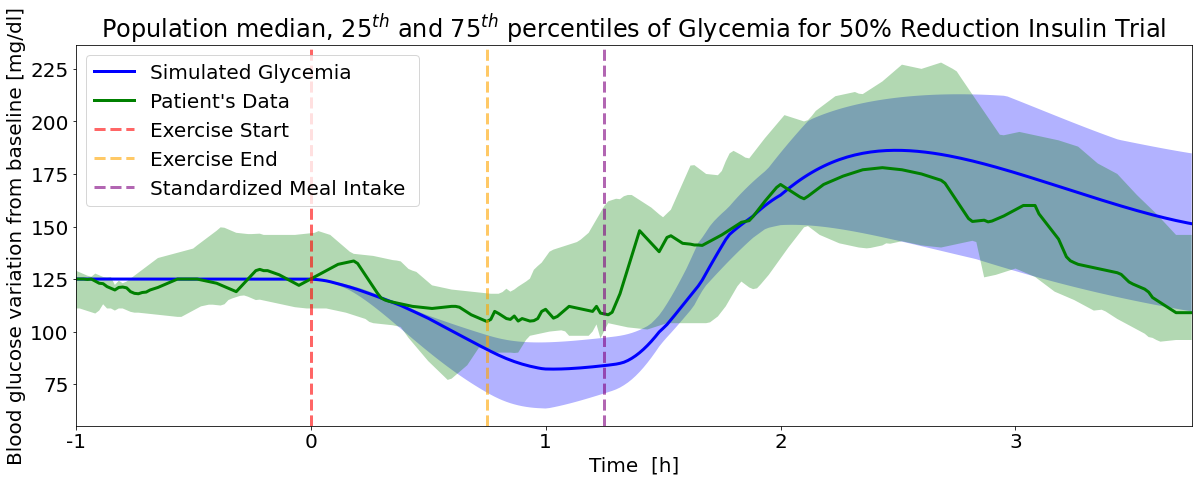

In [ ]:
# Both plots together

plt.figure(figsize=(20,7))
plt.margins(x=0)
plt.fill_between(range(len(df_50reduc_simulated_75percentile.values)), df_50reduc_simulated_75percentile.values[:,0], df_50reduc_simulated_25percentile.values[:,0],facecolor='blue', alpha=0.3)
plt.plot(df_50reduc_simulated_50percentile.values, linewidth=3 , color='blue' , label='Simulated Glycemia')

offset_to_125 = 125 - df_50dec_50percentile_interpolated.values[:,0][0]
plt.fill_between(range(len(df_50dec_75percentile_interpolated)), df_50dec_75percentile_interpolated.values[:,0]+offset_to_125, 
                 df_50dec_25percentile_interpolated.values[:,0]+offset_to_125 ,facecolor='green', alpha=0.3)

plt.plot(df_50dec_50percentile_interpolated.values[:,0]+offset_to_125, linewidth=3,  color='green', label= 'Patient\'s Data')

plt.axvline(x =60, color = 'red', label = 'Exercise Start', linewidth=3, alpha=0.6, linestyle='--')
plt.axvline(x =60+45, color = 'orange', label = 'Exercise End',linewidth=3,  alpha=0.6, linestyle='--')
plt.axvline(x =60+45+30, color = 'purple', label = 'Standardized Meal Intake ',linewidth=3,  alpha=0.6,linestyle='--')
plt.locator_params(axis='x', nbins=285/15)
plt.xticks(ticks=np.arange(0, len(df_50reduc_simulated_pw)+1, 60), labels=np.arange(int(-60/60), int((len(df_50reduc_simulated_pw)-60)/60)+1))
plt.legend(loc=2)
plt.xlabel('Time  [h]')
plt.ylabel('Blood glucose variation from baseline [mg/dl]' )
plt.title('Population median, $25^{th}$ and $75^{th}$ percentiles of Glycemia for 50% Reduction Insulin Trial')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/plots/compariosn_50%reduction_trial_percentiles_color_simulated_50reduc_data.png', dti=320)

plt.show()

# Comparing simulated data vs protocol J dataset - Glucose Tabs Trial

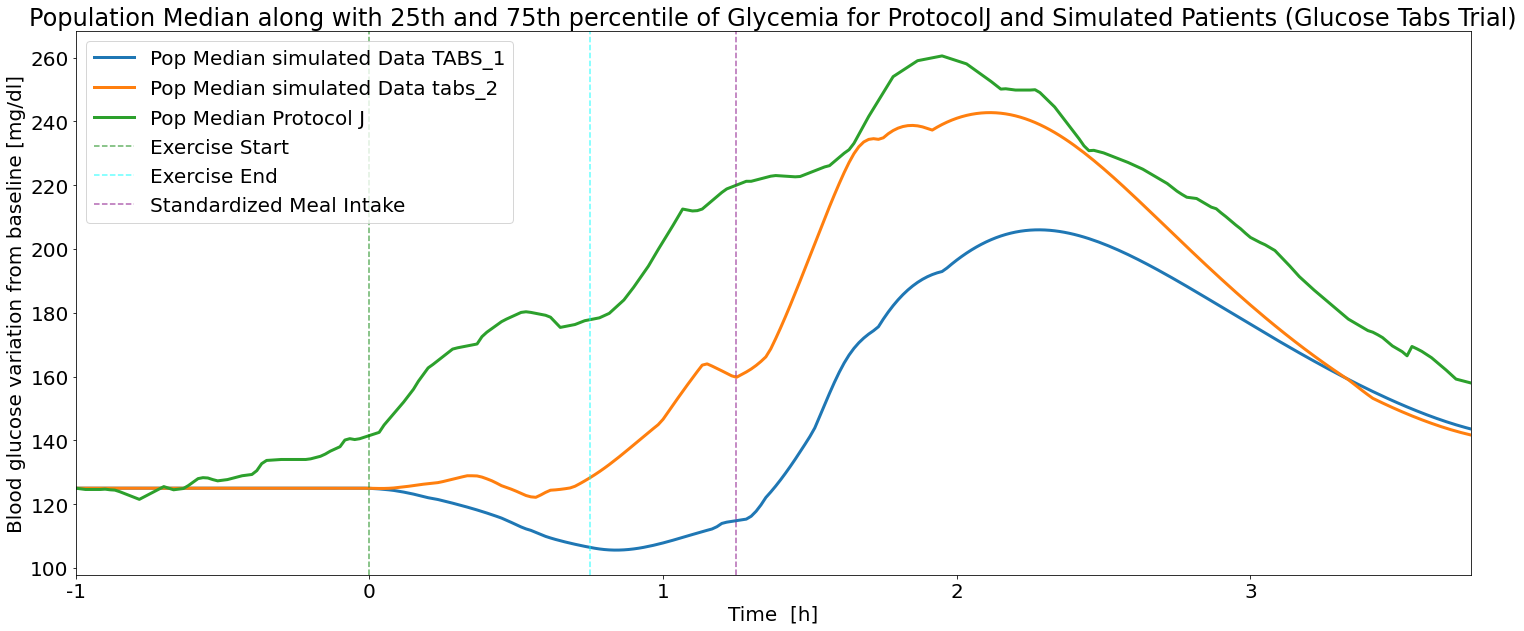

In [ ]:
df_tabs_1_simulated_50percentile= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_tabs_1/df_tabs_1_simulated_50percentile.csv')
df_tabs_2_simulated_50percentile= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_tabs_2/df_tabs_2_simulated_50percentile.csv')
df_tabs_50percentile_interpolated = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_tabs_interpolated_50percentile.csv').values[:,0]

plt.figure(figsize=(25,10))
offset_to_125 = 125 - df_tabs_50percentile_interpolated[0]
plt.margins(x=0)
plt.plot(df_tabs_1_simulated_50percentile, label='Pop Median simulated Data TABS_1', linewidth=3)
plt.plot(df_tabs_2_simulated_50percentile, label='Pop Median simulated Data tabs_2', linewidth=3)
plt.plot(df_tabs_50percentile_interpolated+offset_to_125, label='Pop Median Protocol J', linewidth=3)

plt.axvline(x =60, color = 'green', label = 'Exercise Start', alpha=0.6, linestyle='--')
plt.axvline(x =60+45, color = 'cyan', label = 'Exercise End', alpha=0.6, linestyle='--')
plt.axvline(x =60+45+30, color = 'purple', label = 'Standardized Meal Intake ', alpha=0.6,linestyle='--')
plt.locator_params(axis='x', nbins=285/15)
plt.xticks(ticks=np.arange(0, len(df_control_simulated_pw)+1, 60), labels=np.arange(int(-60/60), int((len(df_control_simulated_pw)-60)/60)+1))
plt.legend(loc=2)
plt.xlabel('Time  [h]')
plt.ylabel('Blood glucose variation from baseline [mg/dl]' )

plt.legend()

plt.title('Population Median along with 25th and 75th percentile of Glycemia for ProtocolJ and Simulated Patients (Glucose Tabs Trial)')
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/plots/protoclJ_simulated_data_tabs1and_2_median.png', dti=600)

plt.show()


In [ ]:
df_tabs_2_simulated_pw= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_tabs_2/df_tabs_2_simulated_pw.csv')
df_tabs_ex_pw_interpolated= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_tabs_ex_pw_interpolated.csv')


df_tabs_2_simulated_75percentile= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_tabs_2/df_tabs_2_simulated_75percentile.csv')
df_tabs_2_simulated_25percentile= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_tabs_2/df_tabs_2_simulated_25percentile.csv')
df_tabs_2_simulated_50percentile= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/simulated_data_4/data_simulated_tabs_2/df_tabs_2_simulated_50percentile.csv')

df_tabs_75percentile_interpolated= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_tabs_interpolated_75percentile.csv')
df_tabs_25percentile_interpolated= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_tabs_interpolated_25percentile.csv')
df_tabs_50percentile_interpolated= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/preprocessed_data/-60minTo2.5hours_after_meal/df_tabs_interpolated_50percentile.csv')


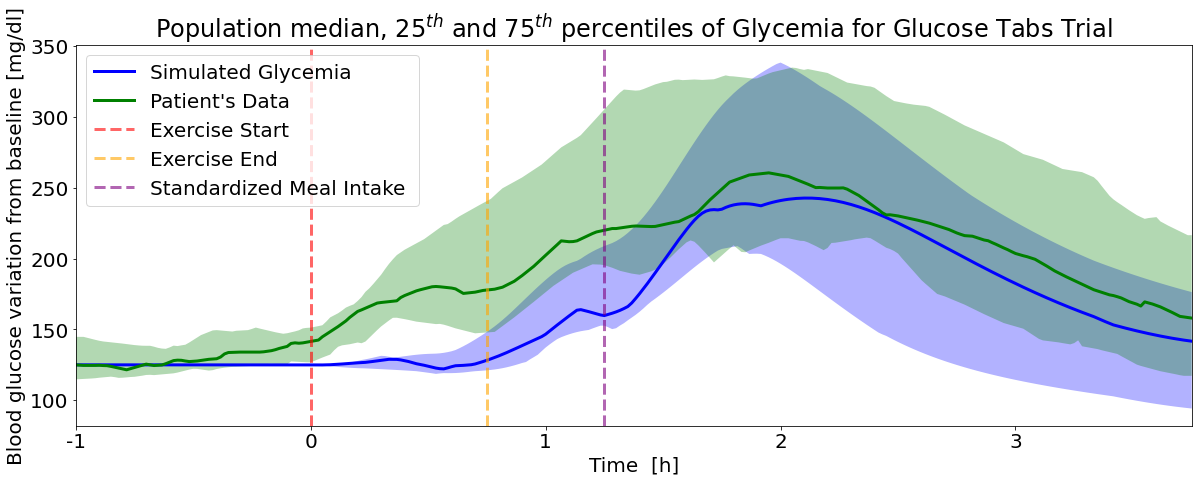

In [ ]:
# Both plots together

plt.figure(figsize=(20,7))
plt.margins(x=0)
plt.fill_between(range(len(df_tabs_2_simulated_75percentile.values)), df_tabs_2_simulated_75percentile.values[:,0], df_tabs_2_simulated_25percentile.values[:,0],facecolor='blue', alpha=0.3)
plt.plot(df_tabs_2_simulated_50percentile.values, linewidth=3 , color='blue' , label='Simulated Glycemia')

offset_to_125 = 125 - df_tabs_50percentile_interpolated.values[:,0][0]
plt.fill_between(range(len(df_tabs_75percentile_interpolated)), df_tabs_75percentile_interpolated.values[:,0]+offset_to_125, 
                 df_tabs_25percentile_interpolated.values[:,0]+offset_to_125 ,facecolor='green', alpha=0.3)

plt.plot(df_tabs_50percentile_interpolated.values[:,0]+offset_to_125, linewidth=3,  color='green', label= 'Patient\'s Data')

plt.axvline(x =60, color = 'red', label = 'Exercise Start', alpha=0.6,linewidth=3,  linestyle='--')
plt.axvline(x =60+45, color = 'orange', label = 'Exercise End', alpha=0.6,linewidth=3,  linestyle='--')
plt.axvline(x =60+45+30, color = 'purple', label = 'Standardized Meal Intake ',linewidth=3,  alpha=0.6,linestyle='--')
plt.locator_params(axis='x', nbins=285/15)
plt.xticks(ticks=np.arange(0, len(df_tabs_2_simulated_pw)+1, 60), labels=np.arange(int(-60/60), int((len(df_tabs_2_simulated_pw)-60)/60)+1))
plt.legend(loc=2)
plt.xlabel('Time  [h]')
plt.ylabel('Blood glucose variation from baseline [mg/dl]' )
plt.title('Population median, $25^{th}$ and $75^{th}$ percentiles of Glycemia for Glucose Tabs Trial')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/LMEM-SHAP/plots/compariosn_tabs_trial_percentiles_simulated_data_tabs_2.png', dti=320)

plt.show()




